# Usage

In this notebook we will see how to:
- train and test a binary classifier within a cross-validation framework;
- accumulate ground-truths and predictions and
- visualize calibration using the modelsight's `hosmer_lemeshow_plot` function.

In [ ]:
import os
import sys

sys.path.insert(0, os.path.abspath("../"))

In [17]:
SEED = 1234
N_REPEATS = 10
N_SPLITS = 10

## Load dataset

In this example, we will use the Breast Cancer Wisconsin dataset, which consists of features computed from a digitized image of a fine needle aspirate of a breast mass.
It's a binary classification problem where the dependent variable is the biopsy's outcome: M is malignant and B is benign.

We can load the dataset using `scikit-learn.datasets.load_breast_cancer`.

In [4]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

In [6]:
y.value_counts(normalize=True)

target
1    0.627417
0    0.372583
Name: proportion, dtype: float64

We can see that 62.7% of breast cancers were malignant.

In [13]:
X.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

This is a toy dataset, hence it's super clean with no missing values.

## Train and validate model within a cross-validation scheme

In [20]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_repeats=N_REPEATS, 
                             n_splits=N_SPLITS, 
                             random_state=SEED)

cv_results = {
    "gt_train": [],
    "gt_val": [],
    "probas_train": [],
    "probas_val": []
}

for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    Xtrain, ytrain = X.iloc[train_idx, :], y.iloc[train_idx]
    Xval, yval = X.iloc[val_idx, :], y.iloc[val_idx]

    model = ExplainableBoostingClassifier(random_state=SEED,
                                            interactions=6,
                                            learning_rate=0.02,
                                            min_samples_leaf=5,
                                            n_jobs=4)

    # this is a toy example hence we will train the model on all available features
    model.fit(Xtrain, ytrain)

    # accumulate ground-truths
    cv_results["gt_train"].append(ytrain)
    cv_results["gt_val"].append(yval)

    # accumulate predictions
    train_pred_probas = model.predict_proba(Xtrain)[:, 1]
    val_pred_probas = model.predict_proba(Xval)[:, 1]

    cv_results["probas_train"].append(train_pred_probas)
    cv_results["probas_val"].append(val_pred_probas)    

Let's see how this model is performing

In [23]:
import numpy as np
from sklearn.metrics import roc_auc_score, brier_score_loss

In [34]:
roc_aucs = []
for gt, preds in zip(cv_results["gt_val"], cv_results["probas_val"]):
    roc_auc = roc_auc_score(gt, preds)
    roc_aucs.append(roc_auc)

roc_low, roc_med, roc_up = np.percentile(roc_aucs, [2.5, 50, 97.5])
roc_mean = np.mean(roc_aucs)
roc_sd = np.std(roc_aucs)

print(f"Median (95% CI) validation area under the curve: {roc_med:.2f} ({roc_low:.2f} - {roc_up:.2f})")
print(f"Mean ± SD validation area under the curve: {roc_mean:.2f} ± {roc_sd:.2f}")

Median (95% CI) validation area under the curve: 1.00 (0.97 - 1.00)
Mean ± SD validation area under the curve: 0.99 ± 0.01


We will now compute median Brier score (95% CI) and use it to annotate the calibration plot.

In [49]:
briers = []
for gt, preds in zip(cv_results["gt_val"], cv_results["probas_val"]):
    brier = brier_score_loss(gt, preds)
    briers.append(brier)

brier_low, brier_med, brier_up = np.percentile(briers, [2.5, 50, 97.5])

brier_annot = f"{brier_med:.2f} ({brier_low:.2f} - {brier_up:.2f})"

## Assess model calibration

Let's see how well calibrated are the predicted probabilities

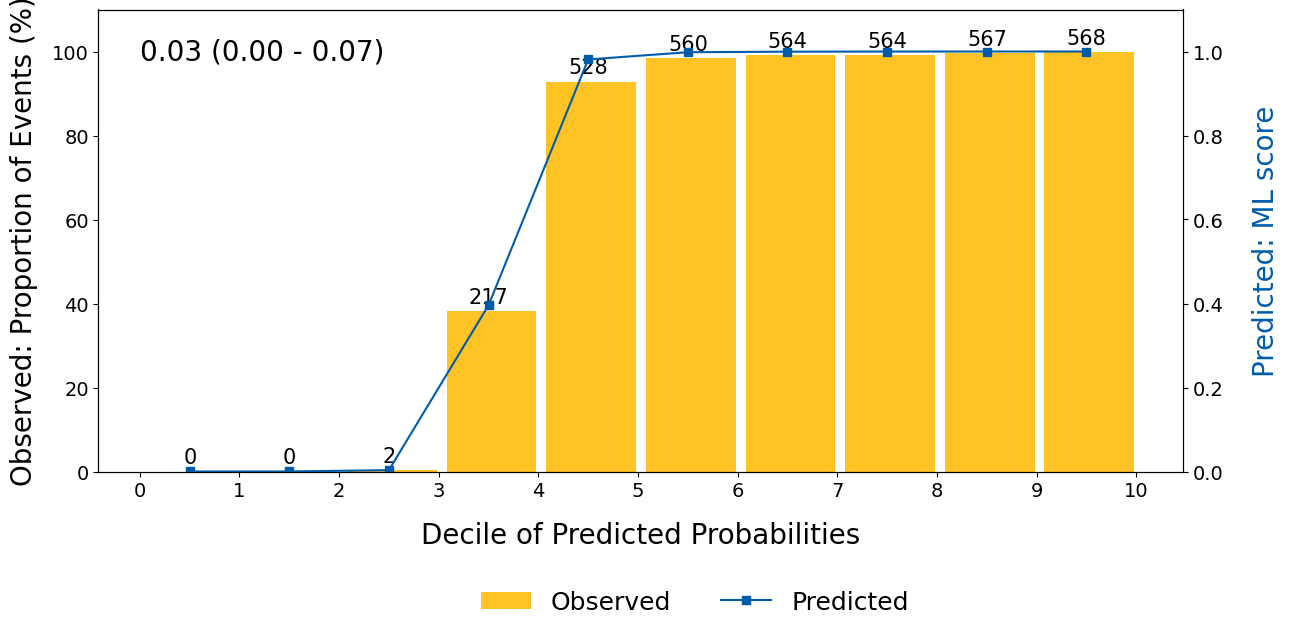

In [52]:
import matplotlib.pyplot as plt
from modelsight.calibration import hosmer_lemeshow_plot

# pool validation ground-truths and predicted probabilities in a long vector
gt_val_conc = np.concatenate(cv_results["gt_val"])
probas_val_conc = np.concatenate(cv_results["probas_val"])

f, ax = plt.subplots(1, 1, figsize=(14,6))

f, ax = hosmer_lemeshow_plot(gt_val_conc,
                             probas_val_conc,
                             n_bins=10,
                             colors=('#005CAB', '#FFC325'),
                             annotate_bars=True,
                             title="",
                             brier_score_annot=brier_annot,
                             ax=ax
                             )

plt.show()

The model appears to be perfectly calibrated, as predicted probabilites match observed ones.

Median brier score also is very low, indicating a good, calibrated classifier.